![Logo UCM](https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Colab/logo_UCM.png)
# Medida de distribuciones espaciales de dosis. Índice gamma
-------

**Objetivos**:
- Calibrar un sistema dosimétrico basado en películas radiocrómicas.
- Emplear medidas tomadas con películas radiocrómicas para evaluar una distribución espacial de dosis mediante análisis del índice gamma.

### Forma de trabajo

En este cuaderno se utilizan herramientas de análisis presentadas en el Tutorial [Uso de Google Colab en Física de la Radioterapia](https://colab.research.google.com/github/csarux/TutorialesFisicaRadioterapia/blob/main/Colab/TutorialColabF%C3%ADsicaRadioterapia.ipynb).
Como ayuda adicional se dan indicaciones en forma de comentarios que indican el código que debe introducirse.

Por ejemplo, una celda de código con el comentario

```
#- Montar gDrive -#
```

deberá ser editada para incluir el código que realiza la acción pedida una vez que haya sido ejecutada. La celda anterior quedará entonces

```
#- Montar gDrive -#
# - Importar el módulo para acceder a Drive
from google.colab import drive
# - Montar el disco
drive.mount('/content/gdrive')
```

### Configuración del entorno de trabajo

Antes de comenzar a desarrollar los objetivos de este cuaderno necesitamos configurar Colab para poder acceder a nuestros datos e instalar un módulo no presente por defecto en Colab.

Mediante las siguientes celdas se tiene que:

- Montar el disco gDrive
- Instalar el módulo `pymedphys`
- Cambiar el directorio de trabajo

In [1]:
# - Importar el módulo para acceder a Drive
from google.colab import drive
# - Montar el disco
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#- Instalar pymedphys -#
%pip install pymedphys

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 22.5 MB/s eta 0:00:00


Cambiar al directorio de trabajo

In [3]:
#- Seleccionar la carpeta de gDrive en la que queramos hacer el análisis y cambiar el directorio de trabajo a ella.
%cd '/content/gdrive/MyDrive'

/content/gdrive/MyDrive


## Primera parte: Calibración del sistema de medida

El sistema dosimétrico se compone de la película como elemento sensible y el escáner con el que se digitaliza la película como elemento lector.

El escáner digitaliza en tres canales de color: R, G, B.

En cada canal de color la medida está compuesta entonces por el par de valores {señal digital $S$, dosis $D$}.

Durante la calibración conocemos la dosis $D$ y medimos la señal digital $S$ para establecer la relación entre ambas.

Durante la medida empleamos la relación anterior para obtener la dosis $D$ a partir de la señal digital $S$ medida.

La calibración se hace más robusta si se restan las contribuciones de los elementos de la película que no son alterados por la radiación.

Para obtener la señal neta producida por el elemento sensible de la película es conveniente pensar en términos de la densidad óptica $d$.

Con el escáner configurado para leer señales digitales codificadas en 16 btis la densidad óptica $d$ se define

\begin{equation}
    d=\log_{10}\frac{2^{16}}{S}
\end{equation}

La densidad óptica es una propiedad aditiva. La densidad debida al elemento sensible se puede obtener restando de la densidad óptica total la contribución de la densidad óptica de una película no irradiada

\begin{equation}
    d=\log_{10}\frac{2^{16}}{S} - \log_{10}\frac{2^{16}}{S_{\text{Bkg}}} = \log_{10}\frac{S_{\text{Bkg}}}{S}
\end{equation}

Para calibrar el sistema vamos a emplear dos aproximaciones diferentes:

### Modelo basado en el crecimiento de dos fases del polímero

\begin{equation}
    d = \phi\cdot (1-e^{-k_r\, D}) + \psi\cdot (1-e^{-k_b\, D})
\end{equation}

Según este modelo la densidad óptica $d$ es una combinación lineal de funciones de saturación $1-e^{-k\, D}$ caracterizadas por un parámetro $k$ propio de cada fase del polímero y del canal del color en el que se determine. Los parámetros $k$ pueden ser conocidos de antemano.

Las fases del polímero se nombran fase roja y fase azul por la banda en la que absorben fundamentalmente la luz. Para los escáneres de sobremesa comúnmente empleados se acepta que para la fase azul el parámetro $k_b$ tiene el mismo valor en los tres canales de color del escáner y que para la fase roja $k_r$ tiene el mismo valor en los canales verde y azul $k_{r, GB}$ y un valor diferente en el canal rojo $k_{r, R}$.

$k_{r,R}$ |$k_{r,GB}$ |$k_b$
--:|--:|--:
0.060|0.039|0.400

Parametros $k$ característicos del escáner utilizado en este cuaderno.

### Modelo racional

\begin{equation}
    d = \log_{10}\frac{c + D}{a + b\,D}
\end{equation}

que de forma equivalente se puede formular

\begin{equation}
    10^{-d} = \frac{a + b\,D}{c + D}
\end{equation}

### Ajuste de los modelos

Los pasos para determinar la calibración del sistema son:

- Leer los datos de calibración. El archivo Excel 'DatosCalibracion.xlsx' contiene datos de dosis en Gy y las señales digitales medidas en los tres canales de color {R, G, B}
- Calcular la densidad óptica debida al elemento sensible
- Modelar la curva de respuesta
- Ajustar los parámetros de la curva de respuesta

Comenzamos por descargar a nuestra carpeta de trabajo los datos de calibración

In [4]:
# - Esta celda no se tiene que modificar. - #
# Importar el módulo pandas
import pandas as pd
# Importar el módulo numpy
import numpy as np
# Descargar los datos de calibración
!wget https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/ComparacionDistribucionesDosis/DatosCalibracion.xlsx
# Leer los datos de calibración en un pandas DataFrame
caldf = pd.read_excel('DatosCalibracion.xlsx')

--2025-03-09 21:32:34--  https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/ComparacionDistribucionesDosis/DatosCalibracion.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8456 (8.3K) [application/octet-stream]
Saving to: ‘DatosCalibracion.xlsx’

DatosCalibracion.xl 100%[===================>]   8.26K  --.-KB/s    in 0.005s  

2025-03-09 21:32:35 (1.65 MB/s) - ‘DatosCalibracion.xlsx’ saved [8456/8456]



Calculamos las densidades ópticas netas, las debidas solo al material sensible. La siguiente celda muestra cómo hacerlo para el canal rojo
y cómo actualizar el DataFrame coun una nueva columna identificada por `dR`

In [5]:
# - Esta celda no se tiene que modificar - #
caldf['dR'] = np.log10(caldf.R[0]/caldf.R)

In [6]:
# - Escribir código similar al anterior para calculas las densidades ópticas de los canales verde 'dG' y azul 'dB' - #
caldf['dB'] = np.log10(caldf.B[0]/caldf.B)
caldf['dG'] = np.log10(caldf.G[0]/caldf.G)

Definir los modelos de las curvas de respuesta

In [7]:
# - Esta celda no se tiene que modificar. Ejecutarla para definir las funciones que describen los modelos - #

# Modelo basado en el crecimiento de dos fases del polímero.
## Definimos las funciones de saturación de cada fase y canal
### Fase roja, canal rojo
def satRrf(D):
    return (1 - np.exp(-0.06*D))

### Fase roja, canales verde y azul
def satGBrf(D):
    return (1 - np.exp(-0.039*D))

### Fase azuk, misma función de saturación para los tres canales.
def satbf(D):
    return (1 - np.exp(-.4*D))

## Definimos la función multiparametrica lineal para el canal rojo.
def R2phf(D, phi, psi):
    return phi * satRrf(D) + psi * satbf(D)

## Definimos la función multiparamétrica lineal para los canales verde y azul. Obtendremos un conjunto de parámetros {phi, psi} diferente para cada canal.
def GB2phf(D, phi, psi):
    return phi * satGBrf(D) + psi * satbf(D)

# Modelo racional: mismo modelo para los tres canales, diferentes parámetros para cada canal.
def ratf(D, a, b, c):
    return np.log10((a+b*D)/(c+D))

#### 1.1 Modelo de crecimiento de dos fases
Realizar el ajuste de regresión lineal múltiple

In [8]:
# - Importar la función LinearRegression del módulo sklearn.linear_model - #
from sklearn.linear_model import LinearRegression

Para el canal rojo

In [9]:
# - Esta celda no se tiene que modificar sirve como modelo del código. Ejecutarla para realizar el ajuste para el canal rojo - #
# Definir el vector de valores dependientes y = densidad óptica neta
y = caldf.dR.values

# Definir la matriz de valores independientes X. Cada columna de X corresponde a un vector que resulta de aplicar la función correspondiente al canal de color y a una fase - #
D = caldf.D
X_R = np.array([satRrf(D),satbf(D)]).transpose()

# - Definir un objeto regressor a partir de la función LiearRegression: ajustar los datos (X, y), obtener los coeficientes de ajuste incluida la ordenada en el origen y las estadísitcas de ajuste
R_regressor = LinearRegression()

R_regressor.fit(X_R, y)

R_phi = R_regressor.coef_[0]
R_psi = R_regressor.coef_[1]
dR0 = R_regressor.intercept_
R_score = R_regressor.score(X_R, y)

# - Mostrar los parámetros de ajuste y el coeficiente de determinación.
print('Coeficientes lineales de ajuste y coeficiente de determinación (score):')
print(r'Canal  rojo. phi: %.3f, psi: %.3f, fondo: %.3f, score: %.3f'%(R_phi, R_psi, dR0, R_score))


Coeficientes lineales de ajuste y coeficiente de determinación (score):
Canal  rojo. phi: 0.402, psi: 0.213, fondo: 0.009, score: 0.998


Repetir para el canal verde

In [10]:
# - Definir el vector de valores dependientes y = densidad óptica neta - #
y_G = caldf.dG.values
# - Definir la matriz de valores independientes X. Cada columna de X corresponde a un vector que resulta de aplicar la función correspondiente al canal de color y a una fase - #
D = caldf.D
X_G = np.array([satGBrf(D),satbf(D)]).transpose()
# - Definir un objeto regressor a partir de la función LiearRegression: ajustar los datos (X, y), obtener los coeficientes de ajuste incluida la ordenada en el origen y las estadísitcas de ajuste
G_regressor = LinearRegression()
G_regressor.fit(X_G, y_G)

G_phi = G_regressor.coef_[0]
G_psi = G_regressor.coef_[1]
dG0 = G_regressor.intercept_
G_score = G_regressor.score(X_G, y_G)
# - Mostrar los parámetros de ajuste y el coeficiente de determinación.
print('Coeficientes lineales de ajuste y coeficiente de determinación (score):')
print(r'Canal  verde. phi: %.3f, psi: %.3f, fondo: %.3f, score: %.3f'%(G_phi, G_psi, dG0, G_score))


Coeficientes lineales de ajuste y coeficiente de determinación (score):
Canal  verde. phi: 0.716, psi: 0.137, fondo: 0.006, score: 0.999


Repetir para el canal azul

In [11]:
# - Definir el vector de valores dependientes y = densidad óptica neta - #
y_B = caldf.dB.values
# - Definir la matriz de valores independientes X. Cada columna de X corresponde a un vector que resulta de aplicar la función correspondiente al canal de color y a una fase - #
D = caldf.D
X_B = np.array([satGBrf(D),satbf(D)]).transpose()
# - Definir un objeto regressor a partir de la función LiearRegression: ajustar los datos (X, y), obtener los coeficientes de ajuste incluida la ordenada en el origen y las estadísitcas de ajuste
B_regressor = LinearRegression()
B_regressor.fit(X_B, y_B)

B_phi = B_regressor.coef_[0]
B_psi = B_regressor.coef_[1]
dB0 = B_regressor.intercept_
B_score = B_regressor.score(X_B, y_B)
# - Mostrar los parámetros de ajuste y el coeficiente de determinación.
print('Coeficientes lineales de ajuste y coeficiente de determinación (score):')
print(r'Canal  azul. phi: %.3f, psi: %.3f, fondo: %.3f, score: %.3f'%(B_phi, B_psi, dB0, B_score))

Coeficientes lineales de ajuste y coeficiente de determinación (score):
Canal  azul. phi: 0.462, psi: 0.069, fondo: 0.006, score: 0.997


In [12]:
# - Importar el módulo de gráficos matplotlib.pyplot con el alias plt - #
import matplotlib.pyplot as plt

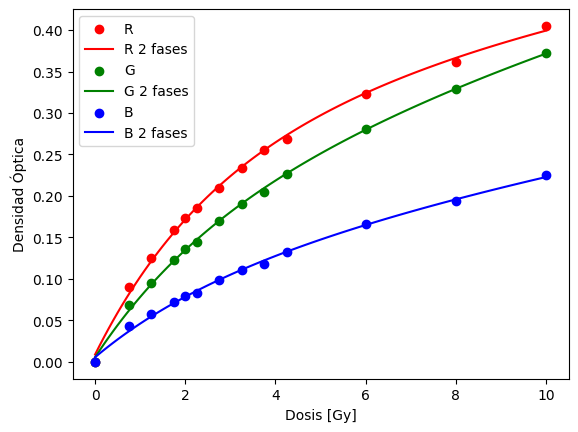

In [13]:
# - Hacer una gráfica de la densidad óptica en función de la dosis en la que se muestren las medidas y su ajuste - #
D = caldf.D
Dg = np.arange(0,10.1,0.1) # vector de Dosis con mayor resolución para el gráfico
fig, ax = plt.subplots()
ax.scatter(D, caldf.dR, color='r', marker='o', label='R')
ax.plot(Dg, R2phf(Dg, *R_regressor.coef_) + R_regressor.intercept_, 'r-', label='R 2 fases')
# - Añadir el código para el canal verde - #
ax.scatter(D, caldf.dG, color='g', marker='o', label='G')
ax.plot(Dg, GB2phf(Dg, *G_regressor.coef_) + G_regressor.intercept_, 'g-', label='G 2 fases')
# - Añadir el código apra canal azul - #
ax.scatter(D, caldf.dB, color='b', marker='o', label='B')
ax.plot(Dg, GB2phf(Dg, *B_regressor.coef_) + B_regressor.intercept_, 'b-', label='B 2 fases')
ax.set_xlabel('Dosis [Gy]')
ax.set_ylabel('Densidad Óptica')
ax.legend(loc='upper left')
plt.show()

Comentar por qué parece necesario tener que incluir un término de ordenda en el origen a pesar de que se han corregido las medidas por la señal digital obtenida para dosis igual a cero.

Hay que incluirla porque para la dosis nula le corresponde una densidad óptica nula también. Como vemos en la gráfica, cerca del origen hay menos concreción para los valores. Entonces, al incluir el término de ordenada en el origen obligamos a pasar el ajuste por el origen, minimizando el error relativo en las zonas cercanas al origen. Así se consigue que se comporte como debe hacerlo teóricamente.

#### 1.2 Modelo basado en funciones racionales

Realizar el ajuste multiparamétrico no lineal

In [14]:
# - Importar la función curve_fit del módulo scipy.optimize - #
from scipy.optimize import curve_fit

Para el canal rojo

In [15]:
# - Esta celda no se tiene que modificar - #
# - Llamar a la fucnión curve fit utilizando como argumentos: la función del modelo racional, las dosis, - #
# - la densidad óptica del canal correspondiente, y una aproximación razonable de los parámetros.        - #
# - Obtener el vector de parámetros y la matriz de covarianzas                                           - #
Rpar, Rcov = curve_fit(ratf, caldf.D, caldf.dR, [3, 0.1, 5])

Para el canal verde

In [16]:
# - Llamar a la fucnión curve fit utilizando como argumentos: la función del modelo racional, las dosis, - #
# - la densidad óptica del canal correspondiente, y una aproximación razonable de los parámetros.        - #
# - Obtener el vector de parámetros y la matriz de covarianzas                                           - #
Gpar, Gcov = curve_fit(ratf, caldf.D, caldf.dG, [3, 0.1, 5])

Para el canal azul

In [17]:
# - Llamar a la fucnión curve fit utilizando como argumentos: la función del modelo racional, las dosis, - #
# - la densidad óptica del canal correspondiente, y una aproximación razonable de los parámetros.        - #
# - Obtener el vector de parámetros y la matriz de covarianzas                                           - #
Bpar, Bcov = curve_fit(ratf, caldf.D, caldf.dB, [3, 0.1, 5])

Mostramos los parámetros de ajuste en forma de tabla recogiéndolos en un DataFrame de pandas

In [18]:
# - Esta celda no se tiene que modificar. Ejecutarla para mostrar los parámetros de ajuste - #
# - Para que funcione correctamente los parámetros de ajuste de los canales verde y azul   - #
# - se han tenido que recoger en las variables Gpar y Bpar                                 - #
ratpdf = pd.DataFrame([Rpar, Gpar, Bpar], index=['R', 'G', 'B'], columns=['a', 'b', 'c'])
print('Parametros del modelo racional:')
ratpdf

Parametros del modelo racional:


,a,b,c
R,11.742521,4.223242,11.578877
G,24.633138,5.544332,24.240558
B,18.954748,2.870969,18.650259


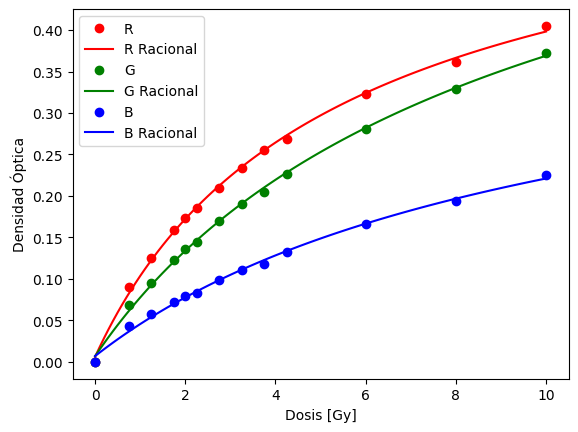

In [19]:
# - Hacer una gráfica de la densidad óptica en función de la dosis en la que se muestren las medidas y su ajuste - #
D = caldf.D
Dg = np.arange(0,10.1,0.1)
fig, ax = plt.subplots()
ax.plot(D, caldf.dR, 'ro', label='R')
ax.plot(Dg, ratf(Dg, *Rpar), 'r-', label='R Racional')
# - Añadir el código para el canal verde - #
ax.plot(D, caldf.dG, 'go', label='G')
ax.plot(Dg, ratf(Dg, *Gpar), 'g-', label='G Racional')
# - Añadir el código apra canal azul - #
ax.plot(D, caldf.dB, 'bo', label='B')
ax.plot(Dg, ratf(Dg, *Bpar), 'b-', label='B Racional')
ax.set_xlabel('Dosis [Gy]')
ax.set_ylabel('Densidad Óptica')
ax.legend(loc='upper left')

Diferencias relativas entre ambos modelos para cada canal para dosis en el rango $(0.5, 10)$ Gy con una resolución de $0.1$ Gy

In [20]:
Dg = np.arange(0.5, 10, 0.1)
erRg = (R2phf(Dg, *R_regressor.coef_) + R_regressor.intercept_ - ratf(Dg, *Rpar))/(R2phf(Dg, *R_regressor.coef_) + R_regressor.intercept_) * 100
# - Añadir el código para los errores relativos en los canales verde y azul
erGg = (GB2phf(Dg, *G_regressor.coef_) + G_regressor.intercept_ - ratf(Dg, *Gpar))/(GB2phf(Dg, *G_regressor.coef_) + G_regressor.intercept_) * 100
erBg = (GB2phf(Dg, *B_regressor.coef_) + B_regressor.intercept_ - ratf(Dg, *Bpar))/(GB2phf(Dg, *B_regressor.coef_) + B_regressor.intercept_) * 100

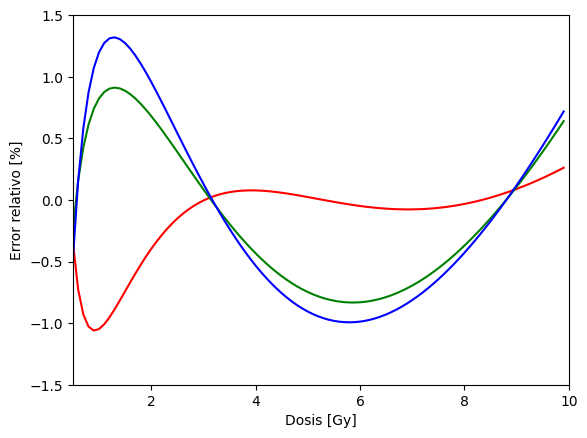

In [21]:
# - Representar en un gráfica los errores relativos en los tres canales - #
fig, ax = plt.subplots()
ax.plot(Dg, erRg, 'r-', label='R')
# - Añadir el código para los canales verde y azul - #
ax.plot(Dg, erGg, 'g-', label='G')
ax.plot(Dg, erBg, 'b-', label='B')

ax.set_xlim(0.5, 10)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('Dosis [Gy]')
ax.set_ylabel('Error relativo [%]')
plt.show()

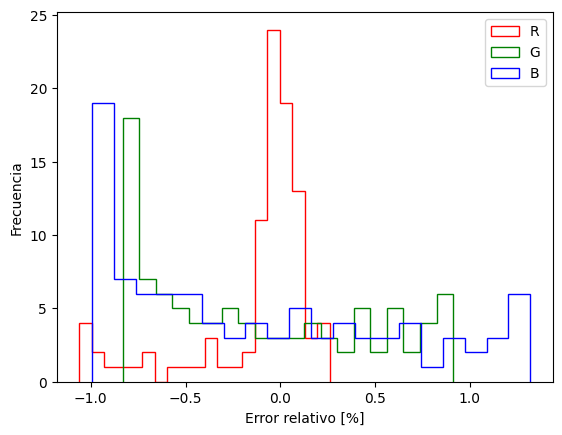

In [22]:
# - Representar mediante histogramas las distribuciones de errores relativos - #
fig, ax = plt.subplots()
ax.hist(erRg, color='r', bins=20, label='R', histtype='step')
# - Añadir el código para los canales verde y azul - #
ax.hist(erGg, color='g', bins=20, label='G', histtype='step')
ax.hist(erBg, color='b', bins=20, label='B', histtype='step')
ax.set_xlabel('Error relativo [%]')
ax.set_ylabel('Frecuencia')
ax.legend()
plt.show()

A la vista de los últimos gráficos realizados:

- Acotar el valor del error relativo entre ambos modelos
- Comentar sobre el tipo de distribución que parece seguir el error relativo (normal, uniforme, lognormal, otra) y sobre su naturaleza (aleatoria, sistemática)
- Comentar acerca de la bondad de los modelos propuestos para representar las medidas realizadas

## Segunda parte: Comparación de distribuciones espaciales de dosis

En el flujo de trabajo de un Servicio de Radioterapia es común tener que comparar distribuciones espaciales de dosis, normalmente la distribución calculada frente a la distribución medida.

Habitualmente estas comparaciones se realizan en términos de la diferencia de dosis, la distancia al acuerdo o una métrica combinada de ambas que se denomina mapa gamma.

Dados dos mapas de dosis, $D_r$ dosis de referencia y $D_e$ dosis de evaluación, distribuidos en el espacio con coordenadas $\mathbf{r}_r$ y $\mathbf{r}_e$ la diferencia de dosis de dosis (*DD*) se define

\begin{equation}
    \Delta D = D_e(\mathbf{r}) - D_r(\mathbf{r})
\end{equation}

Obviamente para calcular la diferencia de dosis ambos mapas de dosis se refieren al mismo marco de referencia, y la diferencia se evalua punto a punto sobre la misma coordenada.

Es habitual expresar la diferencia de dosis en términos relativos, normalmente en porcentaje del valor local

\begin{equation}
    \Delta D = \frac{D_e(\mathbf{e}) - D_r(\mathbf{r})}{D_r(\mathbf{r})}100
\end{equation}

o en porcentaje de un valor fijo global de la dosis de referencia

\begin{equation}
    \Delta D = \frac{D_e(\mathbf{r}) - D_r(\mathbf{r})}{D_{\text{ref}}}100
\end{equation}

El valor $D_{\text{ref}}$ puede ser la dosis de prescripción, la dosis máxima en la distribución o cualquier otro valor que resulte relevante para el tratamiento.

La diferencia de dosis resulta especialmente informativa en regiones de bajo gradiente de dosis. En regiones de alto gradiente de dosis pequeñas variaciones espaciales entre las distribuciones producen grandes diferencias de dosis que sin embargo pueden no tener relevancia clínica.

La distancia al acuerdo (*DTA*) es la distancia $d(\mathbf{r}_e, \mathbf{r}_r)$ que separa los puntos del espacio de evaluación $\mathbf{r}_e$ y de referencia $\mathbf{r}_r$ para un mismo valor de dosis. De forma más imprecisa podemos decir también que es la distancia que separa las curvas de isodosis entre ambas distribuciones. Es espcialmente informativa en regiones de alto gradiente de dosis.

Para criterios de aceptación $\delta D$ y $\delta d$,  sobre la diferencia de dosis y la distancia al acuerdo respectivamente, el índice $\gamma(\delta d, \delta D)$ es una métrica conjunta de la diferencia de dosis $\Delta D(\mathbf{r}_e, \mathbf{r}_r)$ y la distancia $d(\mathbf{r}_e, \mathbf{r}_r)$ definida como

\begin{equation}
\gamma(\mathbf{r}_r,\delta d, \delta D) = \text{min}\{ \sqrt{\frac{d^2(\mathbf{r}_e, \mathbf{r}_r)}{\delta d^2}+\frac{\Delta D^2(\mathbf{r}_e, \mathbf{r}_r)}{\delta D^2}} \} \forall \mathbf{r}_e
\end{equation}

### Objetivos

- Aplicar la calibración realizada en la primera parte para calcular una distribución de evaluación a partir de medidas de la señal digital
- Emplear estas métricas, simplificadas a una sola dimensión, para comparar dos perfiles de dosis
- Realizar un cálculo simplificado del indice gamma en una sola dimensión para profundizar en el concepto del indice gamma
- Comparar nuestro cálculo del índice gamma con el proporcionado por las herramientas del módulo `pymedphys`
- Empleando el módulo `pymedphys` elaborar un mapa gamma de la distribución bidimensional completa

### Simplificaciones

- La señal digital proporcionada por el escáner al leer la película es monocromática y corresponde al canal rojo.
- El sistema dosimétrico se calibra mediante la aproximación racional

**Nota**: Téngase en cuenta que la función de respuesta para el modelo racional es invertible analíticamente.
La inversión de la función de respuesta es necesaria para obtener la función de calibración que nos da la dosis para cada valor de señal digital leído.

Para comenzar la segunda parte leemos las señales digitales correspondientes al canal rojo medidos por el escáner.

Estos valores se proporcionan en formato `dxf`.

Recordemos que `dxf` es un formato de archivo para intercambio de datos de la casa comercial Varian basado en `csv` _**c**omma **s**eparated **v**alues_.

In [ ]:
# - Esta celda no se tiene que modificar. Ejecutarla para descagar los datos - #
# Dosis de referencia
!wget https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/ComparacionDistribucionesDosis/Dosis_Referencia.dxf
# Señal del canal rojo de la imagen digitalizada de la distribución de dosis de evaluación
!wget https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Enunciados/ComparacionDistribucionesDosis/Digital_signal_evaluation.dxf

Leer en DataFrames de pandas los datos de la dosis de referencia y la señal digital correspondiente a la dosis de evaluación

In [ ]:
# - Esta celda no se tiene que modificar. Ejecutarla para leer los datos descargados - #
Drdf = pd.read_csv('Dosis_Referencia.dxf', header=47, sep='\t', names=np.arange(160))
Rdf = pd.read_csv('Digital_signal_evaluation.dxf', header=47, sep='\t', names=np.arange(160))

Calcular la dosis de evaluación a partir de la señal digital

Teniendo en cuenta la definición de la densidad ótpica $d$ a partir de la señal digital $S$

\begin{equation}
    d=\log_{10}\frac{2^{16}}{S}
\end{equation}

podemos invertir la función de respuesta
\begin{equation}
    d = \log_{10}\frac{c + D}{a + b\,D} \\
    \frac{S}{2^{16}} = \frac{c + D}{a + b\,D} \\
    (c + D)\, \frac{2^{16}}{S} = a + b\,D \\
    c\,\frac{2^{16}}{S} - a = (b - \frac{2^{16}}{S})\, D \\
    D = \frac{c\frac{2^{16}}{S} - a}{b - 2^{16}/S}
\end{equation}


In [ ]:
# - Definir la función de calibración invertiendo la función de respuesta ajustada en la primera parte. - #
# - Para ello completar el siguiente cuerpo de código para definir una función que nos dé la dosis      - #
# - a partir de los valores de la señal digital R del canal rojo y de los parámetros a, b, c del        - #
# - modelo racional correspondiente a ese canal.                                                        - #
def Df(R, a, b, c):
    return

In [ ]:
# - Esta celda no se tiene que modificar - #
# - Aplicar la función de calibración a las señales digitales del canal rojo y definir con las dosis de evaluación obtenidas el DataFrame Dedf - #
Dedf = pd.DataFrame(Df(Rdf.values, *Rpar))

Para simplificar el análisis mediante el índice gamma reducimos la distribución a una sola dimensión.

Definimos la coordenada para extraer el perfil de dosis y extraemos los perfiles

In [ ]:
# - Esta celda no se tiene que modificar - #

# Definir la coordenada de referencia del perfil de dosis - #
xprf = 80

# Extraer los perfiles de dosis
Drv = Drdf[xprf] # Vector de dosis de referencia
Dev = Dedf[xprf] # Vector de dosis de evaluación

Repersentamos gráficamente ambos perfiles de dosis. Para realizar esta figura sacamos partido de que los perfiles están tomados con un tamaño de pixel de 1 mm, por lo que no es neceario dar explicitamente la variable independiente.

In [ ]:
# - Código matplotlib del gráfico de comparación de ambos perfiles - #
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(Drv, 'r-', label='Referencia')
# Añadir el código para el perfil de evaluación
ax.set_ylabel('Dosis [Gy]')
ax.set_xlabel('x [mm]')
ax.legend()
plt.show()

Para realizar un cálculo simplificado del índice gamma para un criterio de acuerdo de 3%, 3 mm calculamos primero un array con la diferencia de dosis relativa al valor local de la dosis de referencia y otro con la diferencia de dosis relativa al valor máximo de dosis en el perfil de referencia. Expresamos los resultados en porcentaje.

In [ ]:
# - Código numpy para calcular las diferencias relativas de dosis locales y globales - #
DDlv = (Dev - Drv) / Drv * 100 # Diferencia locales
Drm = Drv.max() # referencia global de dosis. Tomamos el máximo de la distribucikón de dosis de referencia
# - Añadir el código para calcular el vector con la diferencia de dosis global DDgv

Representamos gráficamente las diferencias relativas de dosis globales y locales

In [ ]:
#- Código matplotlib del gráfico de las diferencias relativas de dosis globales y locales  -#
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(DDgv, 'r-', label='Global')
# - Añadir el código para mostrar las diferencias locales de dosis
ax.set_ylabel('$\Delta$D [%]')
ax.set_xlabel('x [mm]')
ax.legend()
plt.show()

En lo que sigue nos referiremos solo al criterio global. Se deja como ejercicio particularizarlo para el criterio local.

En `numpy`es sencillo generar un array a partir de los elemento de otro array que cumplen una determinada condición.

Por ejemplo si queremos crear un array `B` formado por los elementos del array `A` que verifican que son mayores que 1 basta con hacer `B = A[A>1]`.

En el ejemplo anterior la condición `A > 1` crea un array de valores booleanos que se puede aplicar a cualquier array de las mismas dimensiones. Por ejemplo para filtrar valores en el array `C` aplicando la condición al array `A` escribimos: `B = C[A>1]`

Filtramos los valores de los perfiles de evaluación y referencia que cumplen que la diferencia relativa global de dosis es superior al 3%

In [ ]:
# - Código numpy para filtrar los valores que no pasan el criterio de diferencia relativa de dosis - #
Dr_DDgt3 = Drv[DDgv > 3]
# - Añadir el código numpy para filtrar los valores del perfil de evaluación con una diferencia global de dosis mayor del 3% De_DDgt3 - #

Representamos gráficamente la parte de los perfiles que no cumplen el criterio de diferencia de dosis

In [ ]:
# - Código matplotlib con la parte de los perfiles que no cumplen el criterio de diferencia de dosis - #
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(Dr_DDgt3, 'r-', label='Referencia')
# - Añadir el código para representar el trozo de perfil de evaluación con diferencias globales de dosis mayores al 3% - #
ax.set_ylabel('Dosis [Gy]')
ax.set_xlabel('x [mm]')
ax.legend()
plt.show()

No necesariamente todos los puntos que no cumplan el criterio sobre la diferencia de dosis no pasan el criterio gamma. De estos puntos hay que excluir al menos aquellos que tengan una distancia al acuerdo menor de 3 mm.

Para calcular la distancia al acuerdo es más fácil invertir la representación anterior y dar la posición en función de la dosis. Obtendremos dos curvas: una para la distribución de referencia y otra para la de evaluación. La distancia al acuerdo lo podemos dar como otro array en el que cálculamos la distancia entre ambas curvas para cada valor de dosis en el perfil de referencia. Recordemos que los perfiles están obtenidos para un tamaño de píxel de 1 mm. El índice de cada elemento de dosis coincide con la posición espacial.

In [ ]:
# - Código matplotlib con la parte de los perfiles que no cumplen el criterio de diferencia de dosis representada la posición en función de la dosis- #
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(Dr_DDgt3, Dr_DDgt3.index, 'r-', label='Referencia')
# - Añadir el código de la representación de la posición en funcón de la dosis de evaluación para la parte del perfil con una diferencia mayor del 3% - #
ax.set_ylabel('Dosis [Gy]')
ax.set_xlabel('x [mm]')
ax.legend()
plt.show()

Como los valores de dosis en el perfil de evaluación no coinciden tenemos que interpolar este perfil.

Consultar la documentación de la función [interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) del módulo `scipy.interpolate`para ver cómo realizar esta interpolación

In [ ]:
# - No modificar esta celda. Ejecutarla para calcular la distancia al acuerdo dta - #
from scipy.interpolate import interp1d
xevainf = interp1d(De_DDgt3, De_DDgt3.index, fill_value='extrapolate')
dta = Dr_DDgt3.index - xevainf(Dr_DDgt3)

Para obtener las posiciones de los puntos con gamma mayor que 1 para criterios de 3%, 3mm de aquellos que no cumplen el criterio de diferencia de dosis del 3% filtramos los que no cumplen el criterio de distancia al acuerdo de 3 mm. Utilizamos la propiedad index para conocer su coordenada.

In [ ]:
# - Esta celda no se tiene que modificar - #
# Definir las coordenada de los puntos con gamma > 1
xgammav = Dr_DDgt3[dta > 3].index[:-1] # [:-1] Añadido para evitar un efecto de borde

Calcular de forma detallada el valor de gamma(3%, 3mm) al comparar ambos perfiles utilizando la función [gamma](https://docs.pymedphys.com/en/latest/users/ref/lib/gamma.html) del módulo `pymedphys`

In [ ]:
# - Importar e invocar la función gamma - #

In [ ]:
# - Esta celda no se tiene que modificar - #
# - Definir el vector de posiciones espaciales en las que se dan las dosis de referencia y de evaluación - #
xv = np.arange(Dev.shape[0])

In [ ]:
# - Calcular el valor de gamma para criterios de 3%, 3 mm                                                - #
# - Utilizar el siguiente esqueleto                                                                      - #
# - gammav = gamma(vector_posiciones, vector_Dreferencia, vector_posiciones, vector_Devaluaciónv, 3, 3)  - #

Representar gráficamente el valor de gamma y comprobar si los puntos en los que gamma > 1 coinciden con buena aproximación con el cálculo simplificado realizado previamente. Dar una explicación cualitativa de las posibles diferencias.

Calcular el índice gamma empleando la función del módulo pymedphys intercambiando en sus argumentos las dosis de referencia y de evaluación. ¿Cambian los valores de gamma? Comentar

### Evaluación del mapa gamma bidimensional

Utilizamos la función `gamma` del módulo `pymedphys` para comparar bidimensionalmente las dos distribuciones de dosis.

**Nota**: Utilizar como modelo el código presentado en el tutorial [Comparación de distribuciones mediante índice gamma](https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Colab/IndiceGammaComparacionDistribuciones.ipynb)

Los pasos necesarios para reaizar la comparación y representar gráficamente los resultados son los siguientes:

- Definir las coordenadas espaciales de ambas distribuciones de dosis. En nuestro caso están definidas para el mismo marco de referencia.
- Invocar la función gamma sobre la distribución de referencia `Drdf.values` y de evaluación `Dedf.values`. Almacenar los resultados en la variable `gamma_map`
- Definir un DataFrame con los resultados `gamma_map_df`.
- Representar gráficamente la distribución de referencia, la de evaluación y el mapa gamma utilizando el módulo `seaborn`. Importarlo mediante `import seaborn as sns`

**Nota**: En el tutorial también utilizamos `ticker`para no sobrecargar de etiquetas los ejes de los gráficos. Para usarlo hacer primero
`import matplotlib.ticker as ticker`

In [ ]:
# - Esta celda no se tiene que modificar - #
import seaborn as sns
import matplotlib.ticker as ticker

In [ ]:
# Coordenadas
xs, ys = # Definición de coordenadas

# Mapa gamma
gamma_map = # Invocar la función gamma

# Definir DataFrame
gamma_map_df = # Definir el DataFrame a partir de gamma_map

# Función auxiliar para los gráficos
def mapplot(ddf, ax, cmap='jet', label='Dosis [Gy]', title=None):
    sns.heatmap(ddf, cmap=cmap, ax=ax, cbar_kws={'label': label})
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_title(title)
    return

# Mostrar los resultados
# - Código matplotlib que muestre los tres mapas: Dosis de referencia, dosis de evaluación y gamma. - #

Del mapa gamma bidimensional podemos extraer los resultados correspondientes al mismo perfil sobre el que hemos realizado el análisis unidimensional y comparar los resultados

In [ ]:
# - Esta celda no se tiene que modificar - #
# Extraer el perfil de la evaluación bidimensional
gamma2Dv = gamma_map_df[xprf]

# Representar gráficamente ambos perfiles de gamma
fig, ax = plt.subplots()
ax.plot(gammav, 'r-', label='1D')
ax.plot(gamma2Dv, 'b-', label='2D')
ax.set_xlabel('x [mm]')
ax.set_ylabel(r'$\gamma$')
ax.legend()
plt.show()

Explicar las diferencias entre ambos perfiles e identificar cuál de los dos análisis es más exigente. Comentar desde el punto de vista de la relevancia clínica si parece recomendable entonces emplear el criterio más exigente.